In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

# https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec
# β-VAE: https://github.com/1Konny/Beta-VAE

In [2]:
from PIL import Image

def pil_loader_rgba(path: str) -> Image.Image:
    with open(path, 'rb') as f:
        img = Image.open(f)
        img = img.convert('RGBA')  # force alpha channel
        background = Image.new('RGBA', img.size, (255, 255, 255))
        alpha_composite = Image.alpha_composite(background, img).convert('RGB')
    return alpha_composite

# 图像增强：https://pytorch.org/vision/main/auto_examples/plot_transforms.html#random-transforms
transform = T.Compose([T.Resize((128, 128)),
                       T.RandomInvert(p=1),
                       T.RandomHorizontalFlip(),
                       T.RandomAffine(degrees=0, translate=(0.1,0.1), interpolation=T.InterpolationMode.BILINEAR),
                       T.RandomInvert(p=1),
                       #T.ColorJitter(hue=0.5, saturation=0.1, contrast=0.2),
                       T.ToTensor()])
'''transform = T.Compose([T.Resize((256, 256)),
                       T.ToTensor()])'''

img = ImageFolder(root='dataset', loader = pil_loader_rgba, transform=transform)

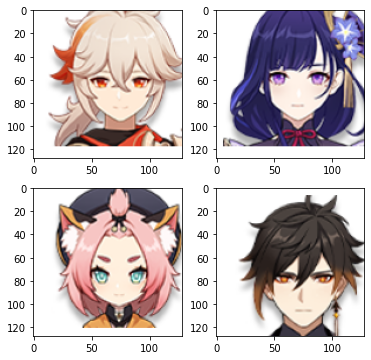

In [3]:
plt.figure(figsize=(6,6))
for i in [16, 17, 18, 19]:
    ax = plt.subplot(221 + i - 16)
    arr, cls = img[i]

    plt.imshow(arr.transpose(0,-1).transpose(0,1), vmin=0, vmax=1)
plt.show()

In [4]:
from model import BetaVAE_H as VAE
from Solver import reconstruction_loss, kl_divergence

model = VAE(nc=3)
model.eval()

xrecon, mu, logvar = model(arr.unsqueeze(0))

In [5]:
rec_loss = reconstruction_loss(arr.unsqueeze(0), xrecon, distribution='gaussian')

In [6]:
total_kld, dimension_wise_kld, mean_kld = kl_divergence(mu, logvar)
total_kld

tensor([5.5124], grad_fn=<MeanBackward1>)

In [7]:
import wandb
import copy

class Reporter:
    def __init__(self, dt, local=False):
        self.dt = dt
        self.loss_count = {}
        self.k = 0.0
        self.local = local
        self.record = []
    
    def report(self):
        if self.k > 0:
            for k in self.loss_count.keys():
                self.loss_count[k] /= self.k
            if self.local:
                self.record.append(copy.deepcopy(self.loss_count))
                for k,v in self.loss_count.items():
                    print(f'{k}: {v}', end='; ')
                print('.')
            else:
                wandb.log(self.loss_count)
    
    def step(self, loss_dict):
        self.k += 1
        for k, v in loss_dict.items():
            if not (k in self.loss_count):
                self.loss_count[k] = 0.0
            self.loss_count[k] += v
        if self.k >= self.dt:
            self.report()
            self.k = 0
            for k in self.loss_count.keys():
                self.loss_count[k] = 0.0

In [21]:
torch.Tensor([1,23]).max().item()

23.0

In [9]:
beta = 5; lr=1e-3; dim=64

wandb.init(config={'beta':beta, 'lr':lr, 'dim':dim}, project="Genshin VAE")  # upload args

gidata = data.DataLoader(img, batch_size=16, shuffle=True)
model = VAE(nc=3, z_dim=dim)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

reporter = Reporter(dt=10)

def max_weight(model):
    max_ = -1
    for para in model.parameters():
        para_max = abs(para.data).max().item()
        if para_max > max_:
            max_ = para_max
    return max_

for i in range(10000):
    loss_count = 0
    k = 0
    for x, cls in gidata:
        optimizer.zero_grad()
        x = x.cuda()
        xrecon, mu, logvar = model(x)
        rec_loss = reconstruction_loss(x, xrecon, distribution='gaussian')
        total_kld, dimension_wise_kld, mean_kld = kl_divergence(mu, logvar)

        loss = rec_loss + beta * total_kld
        loss_count += loss.item()
        loss.backward()
        optimizer.step()
        reporter.step({'epco':i+k/len(gidata), 'loss':loss.item(), 'loss_rec':rec_loss.item(), 'kld':total_kld.item(), 'max_w':max_weight(model)})
        k += 1
    if i % 1000 == 0:
        torch.save(model, f'./models/model_{i}.pth')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [18]:
model.eval()
xrecon, mu, logvar = model(arr.unsqueeze(0).cuda())
xrecon = torch.sigmoid(xrecon)
plt.imshow(xrecon[0].transpose(0, -1).transpose(0, 1).cpu().detach())
plt.show()
plt.imshow(arr.transpose(0, -1).transpose(0, 1).cpu().detach())
plt.show()

RuntimeError: CUDA error: an illegal memory access was encountered

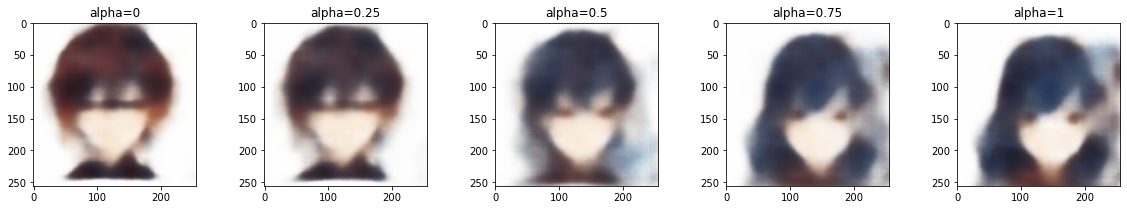

In [16]:
model.cpu()

mu1 = model.encoder(img[17][0].unsqueeze(0))[:, :model.z_dim].detach()
mu2 = model.encoder(img[19][0].unsqueeze(0))[:, :model.z_dim].detach()

fig = plt.figure(figsize=(20,3))
i = 0
for alpha in [0, 0.25, 0.5, 0.75, 1]:
    #alpha = 0.8
    ax1 = plt.subplot(151+i)
    i += 1
    mu_avg = alpha * mu1 + (1-alpha) * mu2

    xrecon = model.decoder(mu_avg).detach()[0].transpose(0, -1).transpose(0, 1)
    xrecon = torch.sigmoid(xrecon)
    plt.imshow(xrecon)
    plt.title(f'alpha={alpha}')
plt.show()